In [3]:
import pandas
import math

In [5]:
df = pandas.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
7766,"LSB INDUSTRIES, INC.",60714,LYNN F. WHITE,False,2015-04-30,2024-04-12
6994,J M SMUCKER Co,91419,DAWN C. WILLOUGHBY,False,2017-06-30,2023-06-30
9404,PAR TECHNOLOGY CORP,708821,SAVNEET SINGH,True,2018-04-23,2024-04-23
2218,CHEMED CORP,19584,THOMAS C. HUTTON,False,2012-04-03,2025-04-07
10121,"RICHARDSON ELECTRONICS, LTD.",355948,PAUL J. PLANTE,True,2011-08-23,2024-08-23


In [9]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
grouped = compensation_and_demographics_raw.groupby('NAME')
compensation_and_demographics = grouped.agg({
    'age': 'max',
    'compensation': 'sum',
    'gender': most_common
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)

compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [11]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [13]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

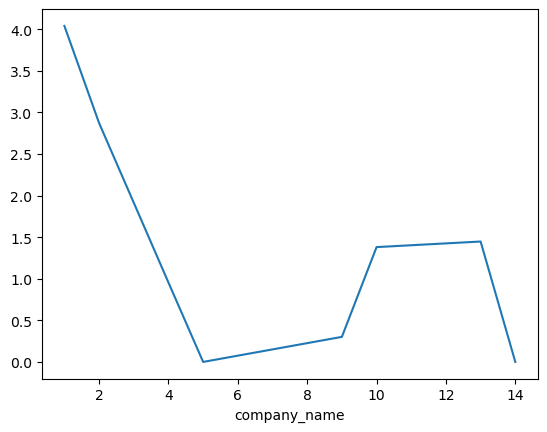

In [15]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [17]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [19]:
# This is creating a biparite graph with companies and directors as nodes
# Edges represent board membership
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [21]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [47]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph))
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)


CPU times: total: 8min 8s
Wall time: 8min 10s


In [49]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [51]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [53]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [55]:
import sklearn.cluster

In [57]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [61]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

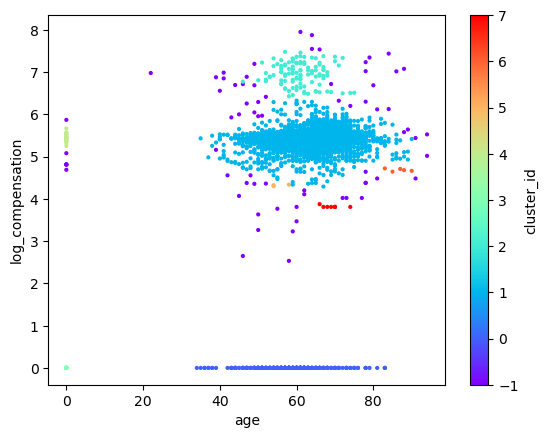

In [63]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [41]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

### This is the code used previously existing measures
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
})
I have added a new centrality so the code looks like this now.

centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph))
})

### Task 2

1. I have change this section of the code as it was repetitive and hard to follow.
From this
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
To this
grouped = compensation_and_demographics_raw.groupby('NAME')
compensation_and_demographics = grouped.agg({
    'age': 'max',
    'compensation': 'sum',
    'gender': most_common
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)

2. The next section par of the code i fixed is:
df.software_background = df.software_background.map(lambda x: x == 't')

I have changed this code to help when there is unexpected values. This is the
df['software_background'] = df['software_background'].fillna('').str.lower() == 't'

3. I have added notation to this section of code 
#) This is creating a biparite graph with companies and directors as nodes
#) Edges represent board membership
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)
4. I have changed this code
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)

To this because it avoids confusion over arbitrary constants, improves readability, and documents the transformation's purpose.
comp = compensation_and_demographics['compensation']
compensation_and_demographics['log_compensation'] = (comp + 1).apply(math.log10)

### Task 3
There is a feature within the dataset that isnt being used which is interesting as why is it in there. Despite the software_background column being loaded and transformed into a boolean, the column is never examined or shown later in the notebook.

### Task 4
The data set i have chosen invloves people who are currently disqualified and banned from running a coroporation in 2025 do to various reasons. It has data such as Name of person, what dates the are banned/qualified, if they were banned/disqualified and what from. Dataset name is bd_per_202506.csv


### Task 5
part(c)
This dataset use network analysis to find prominent directors using publicly available corporate board data.  Despite being lawful, there are important ethical ramifications such as directors' privacy may be jeopardised if they are identified as strategic targets, even though they did not agree to be profiled. Including demographic information like age and gender runs the risk of promoting prejudices, such as normalising older male-dominated leadership. Stereotyping may also result from grouping directors according to characteristics like age or pay. Although network analysis provides strategic insights, there are significant ethical issues when it is used to change board dynamics without consulting people who would be impacted.  Accuracy alone is not enough for responsible data science; it also calls for equity, openness, and respect for people.


B) Take the dataset from (4) and implement whatever it was you wanted to
do with that data.
I have decided to choose this data set as it gives and interesting insight the amount of bans per area. I am hoping to visually show the amount of bans per place and the lengths of the bans.

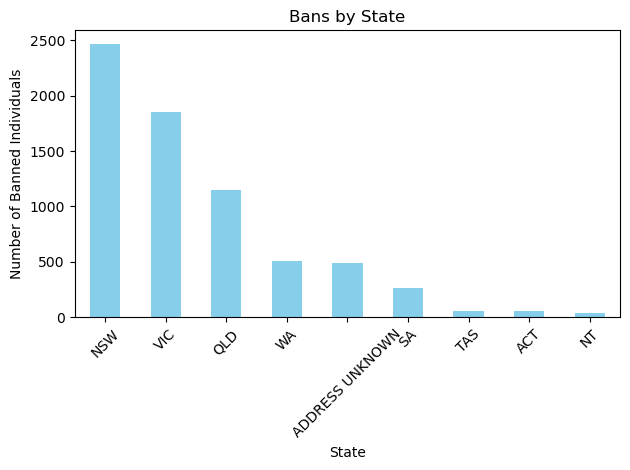

C:\Users\alexd\AppData\Local\Temp\ipykernel_10924\3298634966.py:17: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['BD_PER_START_DT'] = pd.to_datetime(df['BD_PER_START_DT'], errors='coerce')
C:\Users\alexd\AppData\Local\Temp\ipykernel_10924\3298634966.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['BD_PER_END_DT'] = pd.to_datetime(df['BD_PER_END_DT'], errors='coerce')


Total records: 6902
Records with valid durations: 5734
Ban duration statistics:
count     5734.000000
mean      1423.015173
std        975.575465
min          0.000000
25%        731.000000
50%       1277.000000
75%       1826.000000
max      10958.000000
Name: ban_duration_days, dtype: float64


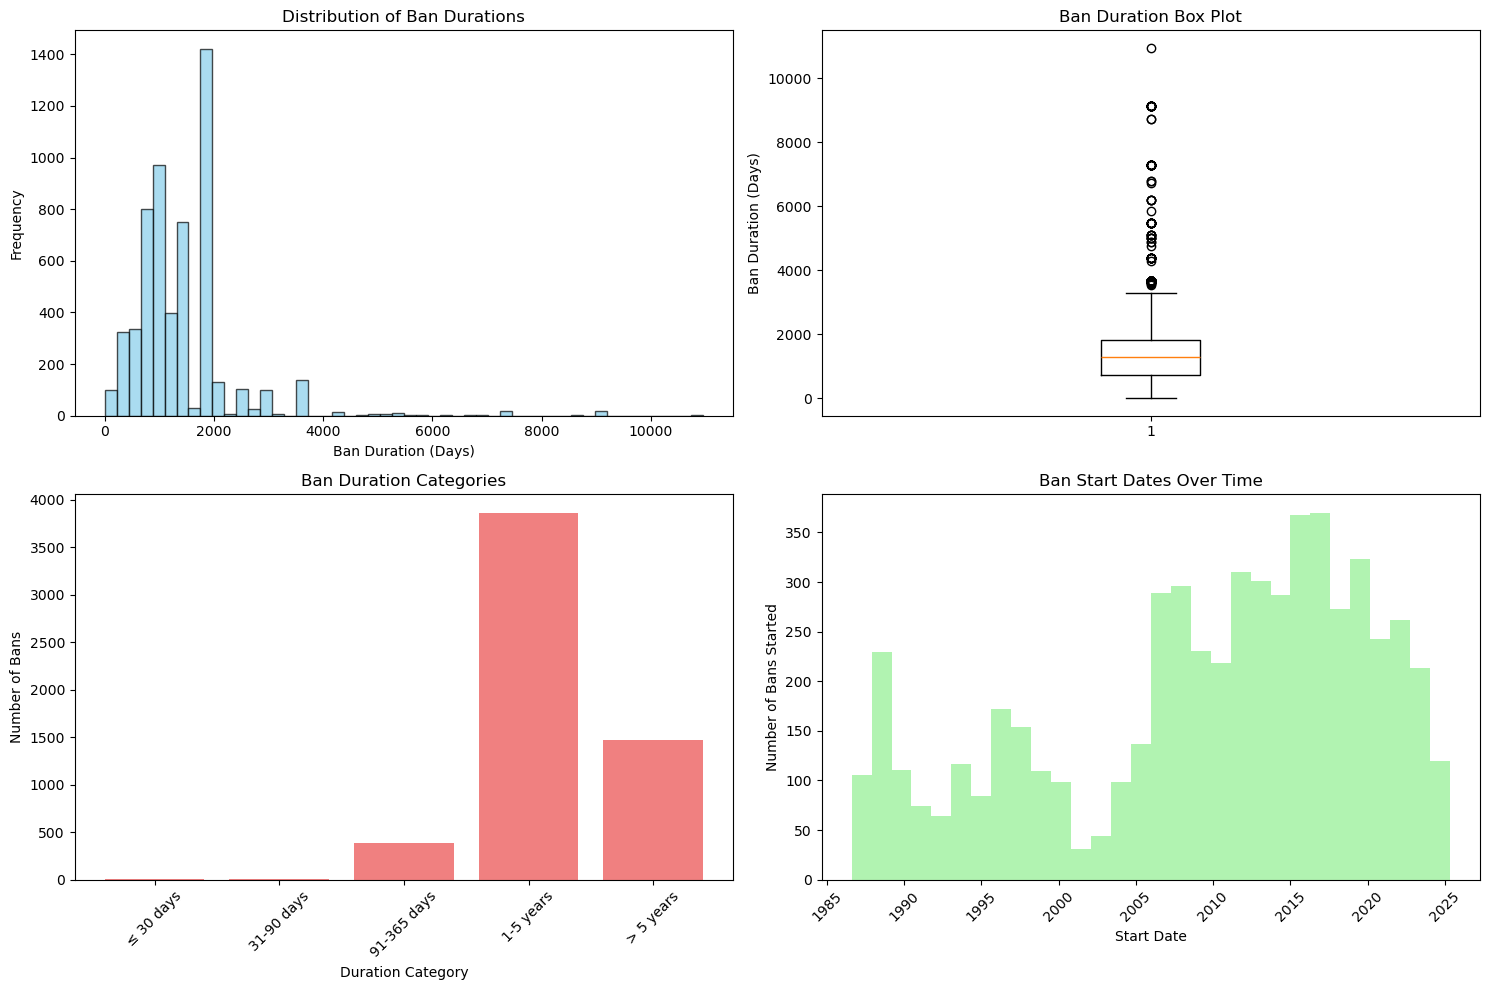


Ban Duration Insights:
Shortest ban: 0.0 days
Longest ban: 10958.0 days
Average ban duration: 1423.0 days
Median ban duration: 1277.0 days

Duration Categories:
≤ 30 days: 12 bans (0.2%)
31-90 days: 8 bans (0.1%)
91-365 days: 382 bans (6.7%)
1-5 years: 3866 bans (67.4%)
> 5 years: 1466 bans (25.6%)

Permanent bans (no end date): 1167


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df = pd.read_csv('bd_per_202506.csv')


df['BD_PER_ADD_STATE'].dropna().value_counts().plot(kind='bar', title='Bans by State', color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Banned Individuals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


df['BD_PER_START_DT'] = pd.to_datetime(df['BD_PER_START_DT'], errors='coerce')
df['BD_PER_END_DT'] = pd.to_datetime(df['BD_PER_END_DT'], errors='coerce')

# Calculate ban duration in days
df['ban_duration_days'] = (df['BD_PER_END_DT'] - df['BD_PER_START_DT']).dt.days

# Remove rows with missing dates or negative durations
df_clean = df.dropna(subset=['ban_duration_days'])
df_clean = df_clean[df_clean['ban_duration_days'] >= 0]

print(f"Total records: {len(df)}")
print(f"Records with valid durations: {len(df_clean)}")
print(f"Ban duration statistics:")
print(df_clean['ban_duration_days'].describe())

# Create multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of ban durations
axes[0, 0].hist(df_clean['ban_duration_days'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Ban Durations')
axes[0, 0].set_xlabel('Ban Duration (Days)')
axes[0, 0].set_ylabel('Frequency')

# 2. Box plot to show outliers
axes[0, 1].boxplot(df_clean['ban_duration_days'])
axes[0, 1].set_title('Ban Duration Box Plot')
axes[0, 1].set_ylabel('Ban Duration (Days)')


def categorize_duration(days):
    if days <= 30:
        return '≤ 30 days'
    elif days <= 90:
        return '31-90 days'
    elif days <= 365:
        return '91-365 days'
    elif days <= 1825:  # 5 years
        return '1-5 years'
    else:
        return '> 5 years'

df_clean['duration_category'] = df_clean['ban_duration_days'].apply(categorize_duration)
category_counts = df_clean['duration_category'].value_counts()

# Order categories logically
category_order = ['≤ 30 days', '31-90 days', '91-365 days', '1-5 years', '> 5 years']
category_counts = category_counts.reindex([cat for cat in category_order if cat in category_counts.index])

axes[1, 0].bar(category_counts.index, category_counts.values, color='lightcoral')
axes[1, 0].set_title('Ban Duration Categories')
axes[1, 0].set_xlabel('Duration Category')
axes[1, 0].set_ylabel('Number of Bans')
axes[1, 0].tick_params(axis='x', rotation=45)


axes[1, 1].hist(df_clean['BD_PER_START_DT'], bins=30, color='lightgreen', alpha=0.7)
axes[1, 1].set_title('Ban Start Dates Over Time')
axes[1, 1].set_xlabel('Start Date')
axes[1, 1].set_ylabel('Number of Bans Started')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


print(f"\nBan Duration Insights:")
print(f"Shortest ban: {df_clean['ban_duration_days'].min()} days")
print(f"Longest ban: {df_clean['ban_duration_days'].max()} days")
print(f"Average ban duration: {df_clean['ban_duration_days'].mean():.1f} days")
print(f"Median ban duration: {df_clean['ban_duration_days'].median():.1f} days")

print(f"\nDuration Categories:")
for category, count in category_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"{category}: {count} bans ({percentage:.1f}%)")

# Show records with permanent bans (no end date)
permanent_bans = df[df['BD_PER_END_DT'].isna() & df['BD_PER_START_DT'].notna()]
print(f"\nPermanent bans (no end date): {len(permanent_bans)}")